Passive Aggressive Classifier 模型

数据预处理

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from datetime import datetime  # 导入 datetime 模块
import time
import shap

# 设置中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

# 1. 数据预处理
df = pd.read_csv('breast cancer.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
feature_names = X.columns  # 保存特征名称

# 分层采样
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 标准化（仅在训练集上拟合）
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 检查分布
print("训练集正负类分布:", y_train.value_counts())
print("测试集正负类分布:", y_test.value_counts())

训练集正负类分布: diagnosis
0    285
1    170
Name: count, dtype: int64
测试集正负类分布: diagnosis
0    72
1    42
Name: count, dtype: int64


超参数调优（GridSearchCV）

In [66]:
# 定义 Passive Aggressive Classifier 模型
base_model = SGDClassifier(loss='hinge', penalty='l2', random_state=42)

# 定义超参数网格
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # 正则化强度
    'max_iter': [500, 1000, 2000],   # 最大迭代次数
    'tol': [1e-4, 1e-3, 1e-2],       # 提前停止容差
    'learning_rate': ['constant', 'optimal', 'invscaling'],  # 学习率策略
    'eta0': [0.01, 0.1, 1.0]         # 初始学习率
}

# 使用 GridSearchCV 进行超参数调优
grid_search = GridSearchCV(
    base_model, 
    param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

# 训练并计时
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

# 输出最佳参数和训练时间
print(f"超参数调优完成！耗时: {end_time - start_time:.2f} 秒")
print("最佳参数:", grid_search.best_params_)
print("最佳交叉验证准确率:", grid_search.best_score_)

# 使用最佳模型
passive_aggressive_model = grid_search.best_estimator_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
超参数调优完成！耗时: 0.59 秒
最佳参数: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'invscaling', 'max_iter': 500, 'tol': 0.001}
最佳交叉验证准确率: 0.9736263736263737


训练 Passive Aggressive Classifier 模型

In [68]:
# 5 折交叉验证
cv_scores = cross_val_score(passive_aggressive_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"5折交叉验证准确率: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

# 训练模型
start_time = time.perf_counter()  # 使用 perf_counter
passive_aggressive_model.fit(X_train, y_train)
end_time = time.perf_counter()    # 使用 perf_counter
training_time = end_time - start_time
print(f"模型训练耗时: {training_time:.4f} 秒")  # 显示 4 位小数

# 预测
y_pred_passive = passive_aggressive_model.predict(X_test)
y_prob_passive = passive_aggressive_model.decision_function(X_test)  # 使用 decision_function
y_prob_passive = (y_prob_passive - y_prob_passive.min()) / (y_prob_passive.max() - y_prob_passive.min())  # 归一化

# 准确率
accuracy_passive = accuracy_score(y_test, y_pred_passive)
print(f"Passive Aggressive 准确率: {accuracy_passive:.4f}")

# 分类报告
print("分类报告:")
print(classification_report(y_test, y_pred_passive))


5折交叉验证准确率: 0.9736 (±0.0329)
模型训练耗时: 0.0014 秒
Passive Aggressive 准确率: 0.9737
分类报告:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



特征重要性分析（基于系数）

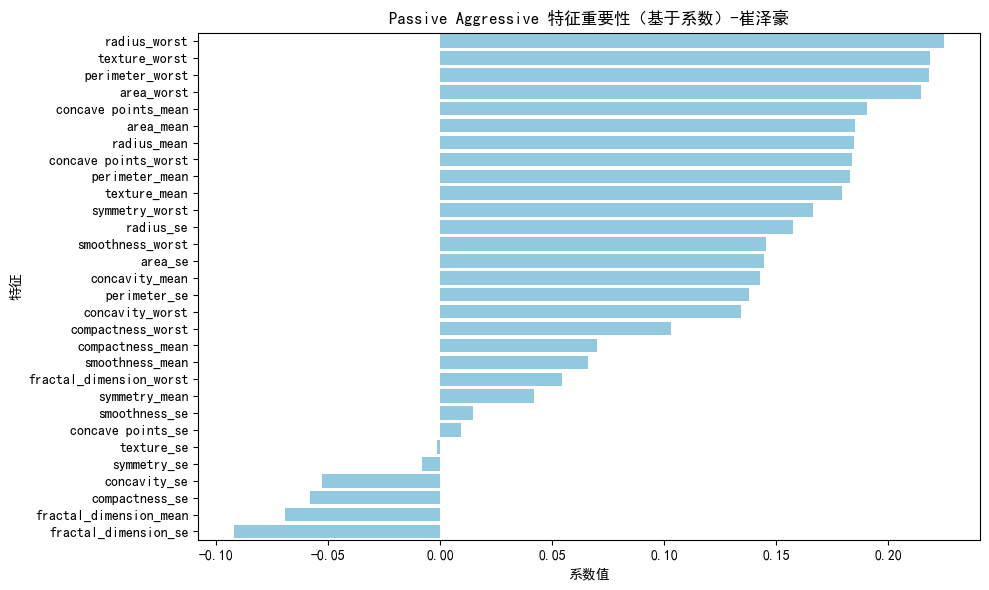

In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# 假设 passive_aggressive_model 和 feature_names 已定义
# 例如：
# passive_aggressive_model = grid_search.best_estimator_
# feature_names = X.columns

# 特征重要性可视化
coef = passive_aggressive_model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, color='skyblue')
plt.title('Passive Aggressive 特征重要性（基于系数）-崔泽豪')
plt.xlabel('系数值')
plt.ylabel('特征')
plt.tight_layout()

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Passive Aggressive Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'passive_aggressive_feature_importance_{timestamp}.png')
plt.savefig(save_path)
plt.show()

混淆矩阵

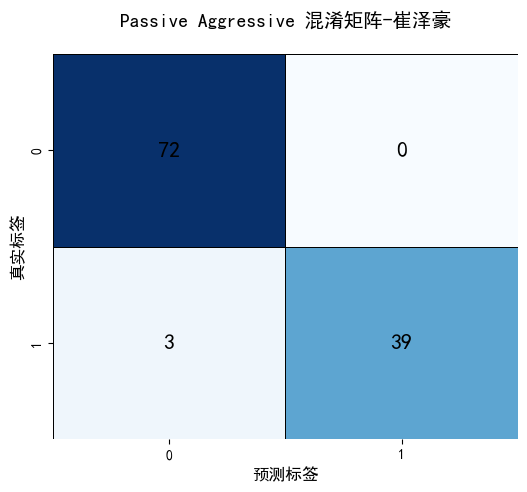

In [84]:
# 混淆矩阵
cm_passive = confusion_matrix(y_test, y_pred_passive)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_passive, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16, "weight": "bold", "color": "black"},
            linewidths=0.5, linecolor='black')
plt.title('Passive Aggressive 混淆矩阵-崔泽豪', fontsize=14, pad=20)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Passive Aggressive Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'passive_aggressive_confusion_matrix_{timestamp}.png')
plt.savefig(save_path)
plt.show()

ROC 曲线

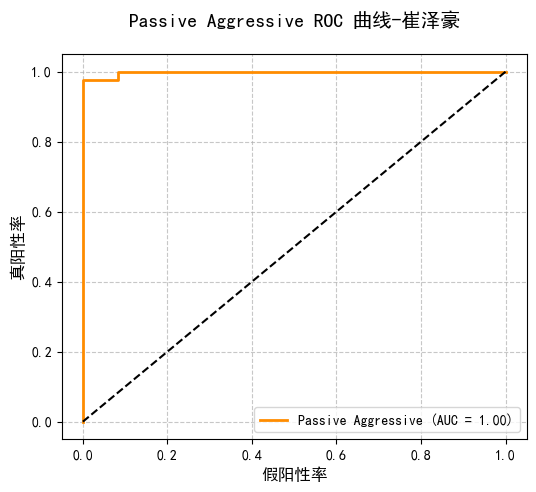

In [80]:
fpr_passive, tpr_passive, _ = roc_curve(y_test, y_prob_passive)
roc_auc_passive = auc(fpr_passive, tpr_passive)
plt.figure(figsize=(6, 5))
plt.plot(fpr_passive, tpr_passive, label=f'Passive Aggressive (AUC = {roc_auc_passive:.2f})', 
         color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlabel('假阳性率', fontsize=12)
plt.ylabel('真阳性率', fontsize=12)
plt.title('Passive Aggressive ROC 曲线-崔泽豪', fontsize=14, pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Passive Aggressive Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'passive_aggressive_roc_curve_{timestamp}.png')
plt.savefig(save_path)
plt.show()

PR 曲线（Precision-Recall Curve）

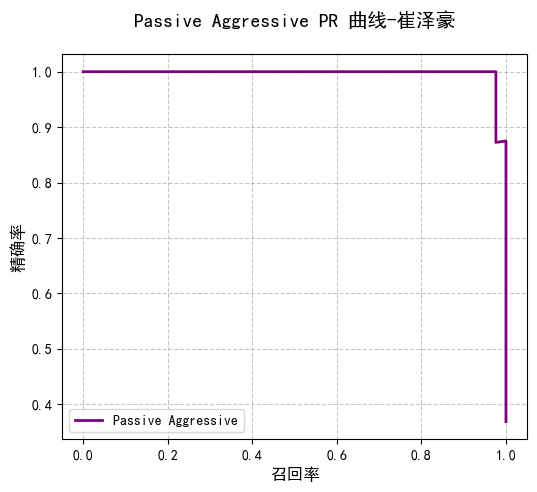

In [82]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_passive)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Passive Aggressive', color='purple', lw=2)
plt.xlabel('召回率', fontsize=12)
plt.ylabel('精确率', fontsize=12)
plt.title('Passive Aggressive PR 曲线-崔泽豪', fontsize=14, pad=20)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Passive Aggressive Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'passive_aggressive_pr_curve_{timestamp}.png')
plt.savefig(save_path)
plt.show()

学习曲线

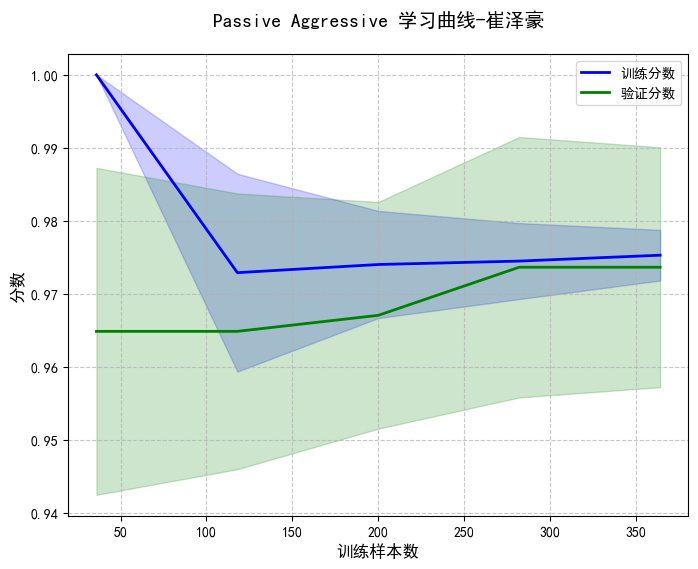

In [86]:
train_sizes, train_scores, val_scores = learning_curve(passive_aggressive_model, X_train, y_train, cv=5, n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label='训练分数', color='blue', lw=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, label='验证分数', color='green', lw=2)
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color='green', alpha=0.2)
plt.title('Passive Aggressive 学习曲线-崔泽豪', fontsize=14, pad=20)
plt.xlabel('训练样本数', fontsize=12)
plt.ylabel('分数', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Passive Aggressive Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'passive_aggressive_learning_curve_{timestamp}.png')
plt.savefig(save_path)
plt.show()

Ridge Classifier模型

数据加载与预处理

In [98]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体支持中文和数学符号
plt.rcParams['axes.unicode_minus'] = False    # ✅ 禁用数学负号，改为普通 ASCII -

# 加载并预处理数据
df = pd.read_csv('breast cancer.csv')
df.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values
# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

L1 选择 + 多项式扩展 + PCA 可视化

✅ 选择特征数: 7
✅ 多项式扩展后维度: 35


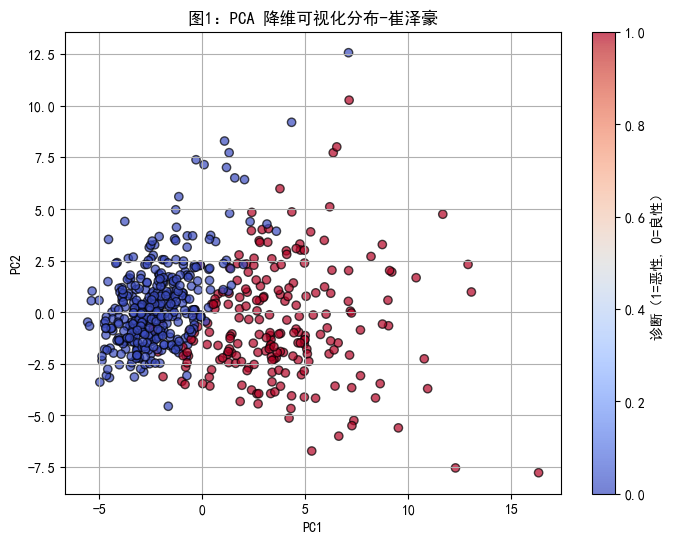

In [101]:
# L1 正则化特征选择
selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.05))
X_selected = selector.fit_transform(X_scaled, y)
print(f"✅ 选择特征数: {X_selected.shape[1]}")

# 多项式特征扩展
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_selected)
print(f"✅ 多项式扩展后维度: {X_poly.shape[1]}")

# PCA 可视化
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', edgecolor='k', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('图1：PCA 降维可视化分布-崔泽豪')
plt.colorbar(label='诊断（1=恶性, 0=良性）')
plt.grid(True)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Ridge Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'pca_visualization_{timestamp}.png')
plt.savefig(save_path)
plt.show()


模型训练与预测

In [107]:
# 划分训练/测试集
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
# 开始计时
start_time = time.time()
# 训练模型
model = RidgeClassifier(alpha=1.0)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)
y_score = model.decision_function(X_test)
y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())

# 结束计时
elapsed = time.time() - start_time
print(f"✅ 训练耗时: {elapsed:.4f} 秒")
print(f"✅ 训练集准确率: {model.score(X_train, y_train):.4f}")
print(f"✅ 测试集准确率: {accuracy_score(y_test, y_pred):.4f}")


✅ 训练耗时: 0.0079 秒
✅ 训练集准确率: 0.9758
✅ 测试集准确率: 0.9561


分类报告 + 混淆矩阵 + ROC

分类报告:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



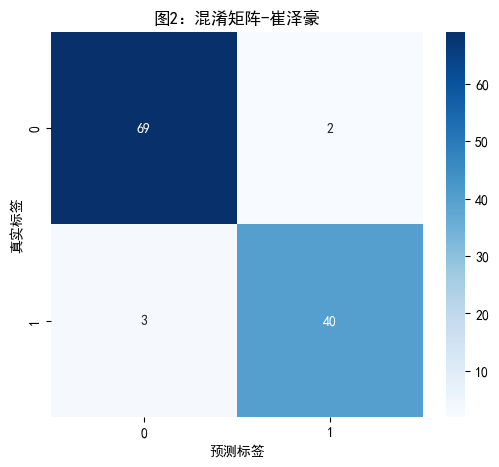

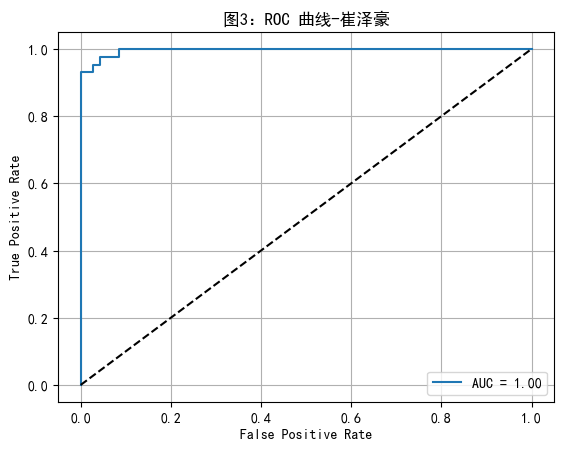

In [111]:
# 分类报告
print("分类报告:\n", classification_report(y_test, y_pred))

# 混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('图2：混淆矩阵-崔泽豪')
plt.xlabel('预测标签')
plt.ylabel('真实标签')

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Ridge Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'confusion_matrix_{timestamp}.png')
plt.savefig(save_path)
plt.show()

# ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('图3：ROC 曲线-崔泽豪')
plt.legend(loc='lower right')
plt.grid(True)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Ridge Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'roc_curve_{timestamp}.png')
plt.savefig(save_path)
plt.show()

学习曲线分析

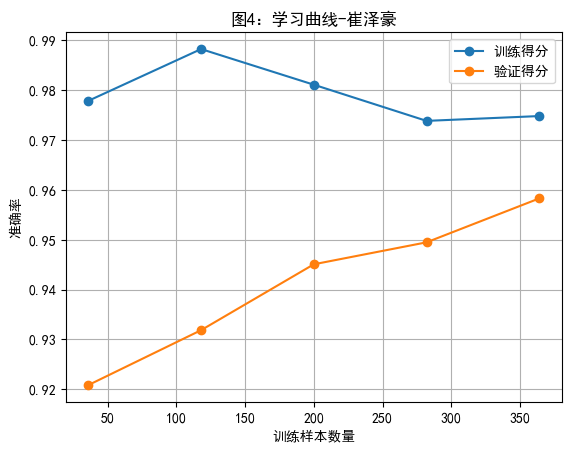

In [113]:
# 学习曲线
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5)
plt.figure()
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='训练得分')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='验证得分')
plt.title('图4：学习曲线-崔泽豪')
plt.xlabel('训练样本数量')
plt.ylabel('准确率')
plt.legend()
plt.grid(True)

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Ridge Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'learning_curve_{timestamp}.png')
plt.savefig(save_path)
plt.show()

正则化强度影响分析

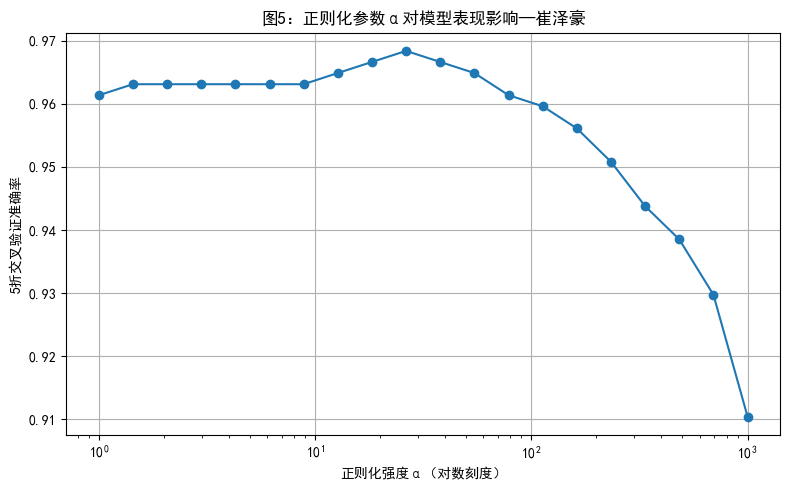

In [115]:
alphas = np.logspace(0, 3, 20)
cv_scores = [cross_val_score(RidgeClassifier(alpha=a), X_poly, y, cv=5).mean()
             for a in alphas]

plt.figure(figsize=(8, 5))
plt.semilogx(alphas, cv_scores, marker='o', linestyle='-')
plt.title('图5：正则化参数α对模型表现影响—崔泽豪')
plt.xlabel('正则化强度α（对数刻度）')
plt.ylabel('5折交叉验证准确率')
plt.grid(True)
plt.tight_layout()

# 指定保存路径并创建目录，添加时间戳
base_save_path = r'C:\Users\Administrator\Desktop\work (1)\work (1)\work\picture\Ridge Classifier'
os.makedirs(base_save_path, exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
save_path = os.path.join(base_save_path, f'alpha_performance_curve_{timestamp}.png')
plt.savefig(save_path)
plt.show()

LightGBM 模型

需要导入的包和其他初始设置

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

try:
    import lightgbm as lgb
    print("LightGBM 版本:", lgb.__version__)
except ImportError:
    print("LightGBM 未安装，请运行 'pip install lightgbm' 或 'conda install -c conda-forge lightgbm' 安装。")
    exit()
import shap
import time
import os

# 设置中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

LightGBM 版本: 4.6.0


数据预处理

In [10]:
df = pd.read_csv('breast cancer.csv')
df = df.drop(['id', 'Unnamed: 32'], axis=1)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop('diagnosis', axis=1).values  # 转换为 numpy 数组
y = df['diagnosis'].values

# 分层采样
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 转换为适合 LightGBM 的格式
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

print("数据预处理完成：X_train shape:", X_train.shape, "X_test shape:", X_test.shape)
print("训练集正负类分布:", pd.Series(y_train).value_counts())
print("测试集正负类分布:", pd.Series(y_test).value_counts())

数据预处理完成：X_train shape: (455, 30) X_test shape: (114, 30)
训练集正负类分布: 0    285
1    170
Name: count, dtype: int64
测试集正负类分布: 0    72
1    42
Name: count, dtype: int64


定义和训练模型

In [19]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

lgb_model = lgb.LGBMClassifier(
    reg_alpha=0.1, reg_lambda=0.1, max_depth=3,
    learning_rate=0.01, n_estimators=200, random_state=42,
    min_data_in_leaf=30,
    force_col_wise=True,
    verbosity=-1
)

# 训练模型（使用早停机制，禁用详细日志）
start_time = time.perf_counter()
eval_set = [(X_train, y_train), (X_test, y_test)]
lgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    eval_metric='binary_logloss',  # 明确指定为 binary_logloss
    eval_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=10, verbose=False),
        lgb.log_evaluation(period=0)
    ]
)
end_time = time.perf_counter()
print(f"LightGBM 模型训练耗时: {end_time - start_time:.4f} 秒")

# 10 折交叉验证 - 准确率
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipeline = make_pipeline(StandardScaler(), lgb_model)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy', verbose=0)
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()
print(f"10折交叉验证准确率: {cv_mean:.4f} (±{cv_std * 2:.4f})")

LightGBM 模型训练耗时: 0.0344 秒
10折交叉验证准确率: 0.9362 (±0.0992)


预测与预估

In [22]:
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM 准确率: {accuracy_lgb:.4f}")

# 分类报告
print("LightGBM 分类报告:")
print(classification_report(y_test, y_pred_lgb))

LightGBM 准确率: 0.9737
LightGBM 分类报告:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



混淆矩阵

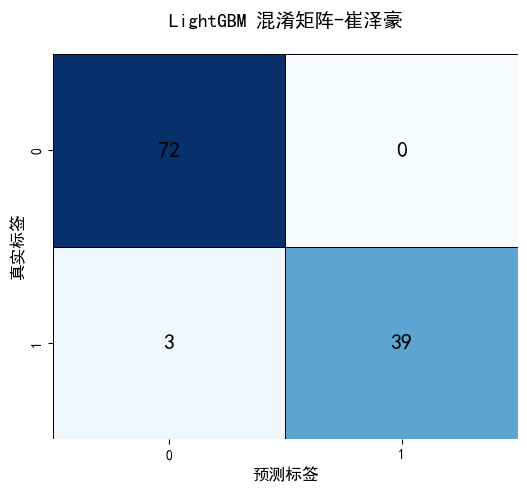

In [25]:
os.makedirs('./picture/LightGBM/', exist_ok=True)
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 16, "weight": "bold", "color": "black"},
            linewidths=0.5, linecolor='black')
plt.title('LightGBM 混淆矩阵-崔泽豪', fontsize=14, pad=20)
plt.xlabel('预测标签', fontsize=12)
plt.ylabel('真实标签', fontsize=12)
plt.savefig('./picture/LightGBM/confusion_matrix.png')
plt.show()

ROC曲线

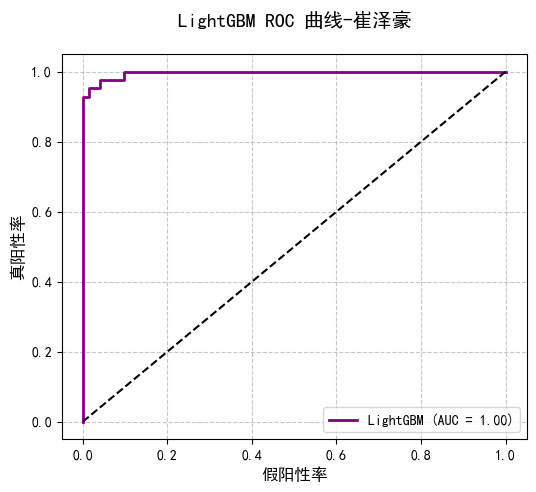

In [28]:
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
plt.figure(figsize=(6, 5))
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})', color='purple', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlabel('假阳性率', fontsize=12)
plt.ylabel('真阳性率', fontsize=12)
plt.title('LightGBM ROC 曲线-崔泽豪', fontsize=14, pad=20)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./picture/LightGBM/roc_curve.png')
plt.show()

PR曲线

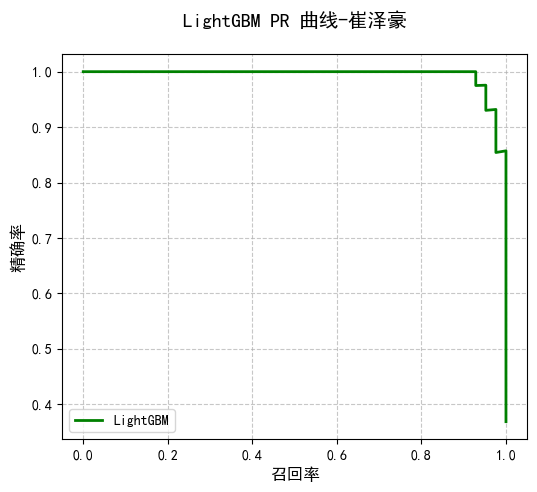

In [31]:
precision, recall, _ = precision_recall_curve(y_test, y_prob_lgb)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='LightGBM', color='green', lw=2)
plt.xlabel('召回率', fontsize=12)
plt.ylabel('精确率', fontsize=12)
plt.title('LightGBM PR 曲线-崔泽豪', fontsize=14, pad=20)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./picture/LightGBM/pr_curve.png')
plt.show()

学习曲线

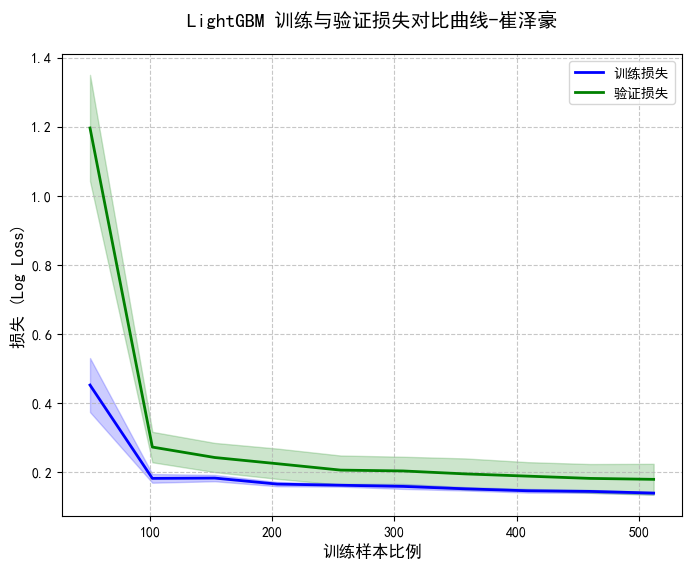

In [34]:
train_sizes, train_loss, val_loss = learning_curve(
    pipeline,
    X, y,
    cv=10,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_log_loss'
)
train_loss_mean = -np.mean(train_loss, axis=1)
train_loss_std = np.std(train_loss, axis=1)
val_loss_mean = -np.mean(val_loss, axis=1)
val_loss_std = np.std(val_loss, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_loss_mean, label='训练损失', color='blue', lw=2)
plt.fill_between(train_sizes, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_loss_mean, label='验证损失', color='green', lw=2)
plt.fill_between(train_sizes, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, color='green', alpha=0.2)
plt.xlabel('训练样本比例', fontsize=12)
plt.ylabel('损失 (Log Loss)', fontsize=12)
plt.title('LightGBM 训练与验证损失对比曲线-崔泽豪', fontsize=14, pad=20)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('./picture/LightGBM/loss_learning_curve.png')
plt.show()

验证集损失曲线（LightGBM 内置）

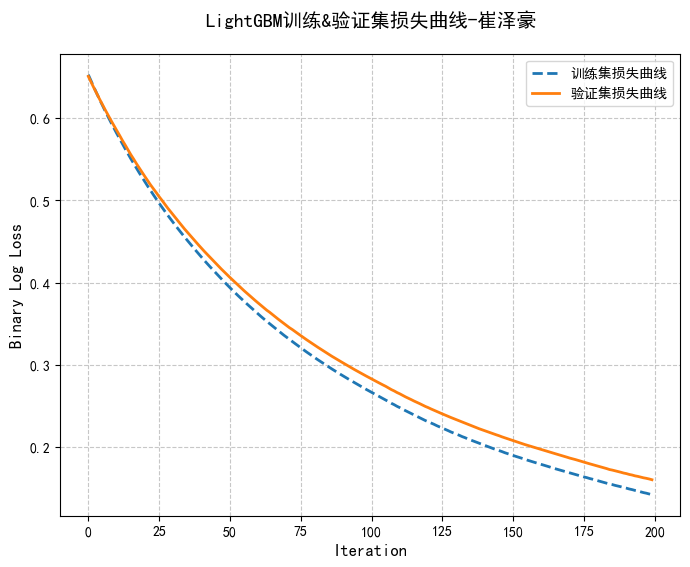

In [40]:
results_dict = lgb_model.evals_result_

plt.figure(figsize=(8, 6))

# 画训练集损失曲线
plt.plot(
    results_dict['train']['binary_logloss'],
    label='训练集损失曲线',
    linestyle='--',
    lw=2
)

# 画验证集损失曲线
plt.plot(
    results_dict['valid']['binary_logloss'],
    label='验证集损失曲线',
    lw=2
)

plt.title('LightGBM训练&验证集损失曲线-崔泽豪', fontsize=14, pad=20)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Binary Log Loss', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('./picture/LightGBM/train_valid_loss_curve.png')
plt.show()